In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone, timedelta
from io import StringIO
import geohash2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")
import import_ipynb
import pm25_nowcast_aqi as aqi

importing Jupyter notebook from pm25_nowcast_aqi.ipynb
PM25: 35.9 AQI: 102


# Extraction - PM25 Clean, without outliers

In [2]:
# Kedro Catalog
pm25_raw = catalog.load('pm25_raw')
# Data Frame Sensors
pm25_raw.head()

2022-09-21 22:39:22,620 - kedro.io.data_catalog - INFO - Loading data from `pm25_raw` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21.0,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20.0,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20.0,20.0,24.0,166.0,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21.0,20.0,24.0,64.0,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22.0,22.0,24.0,49.0,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


In [3]:
# Check Data Types
pm25_raw.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

## Descriptive Statistics

In [4]:
# Describe Data
pm25_raw.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2838.000000,2747.000000,2796.000000,842.000000,2779.000000,2801.000000,2807.000000,2763.000000,2692.000000,2755.000000,2770.000000,2739.000000,2793.000000
mean,21.417195,24.116491,25.281474,38.681710,27.880533,26.601928,16.470609,5.638075,16.235884,32.560436,28.472924,21.766338,25.704261
std,5.746803,5.982577,6.981280,59.070996,11.151621,5.989012,6.511554,2.852142,8.509186,20.869400,12.251082,15.567362,5.954451
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,29.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,31.000000,31.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,44.000000,72.000000,56.000000,1110.000000,182.000000,42.000000,60.000000,12.000000,86.000000,583.000000,170.000000,449.000000,51.000000


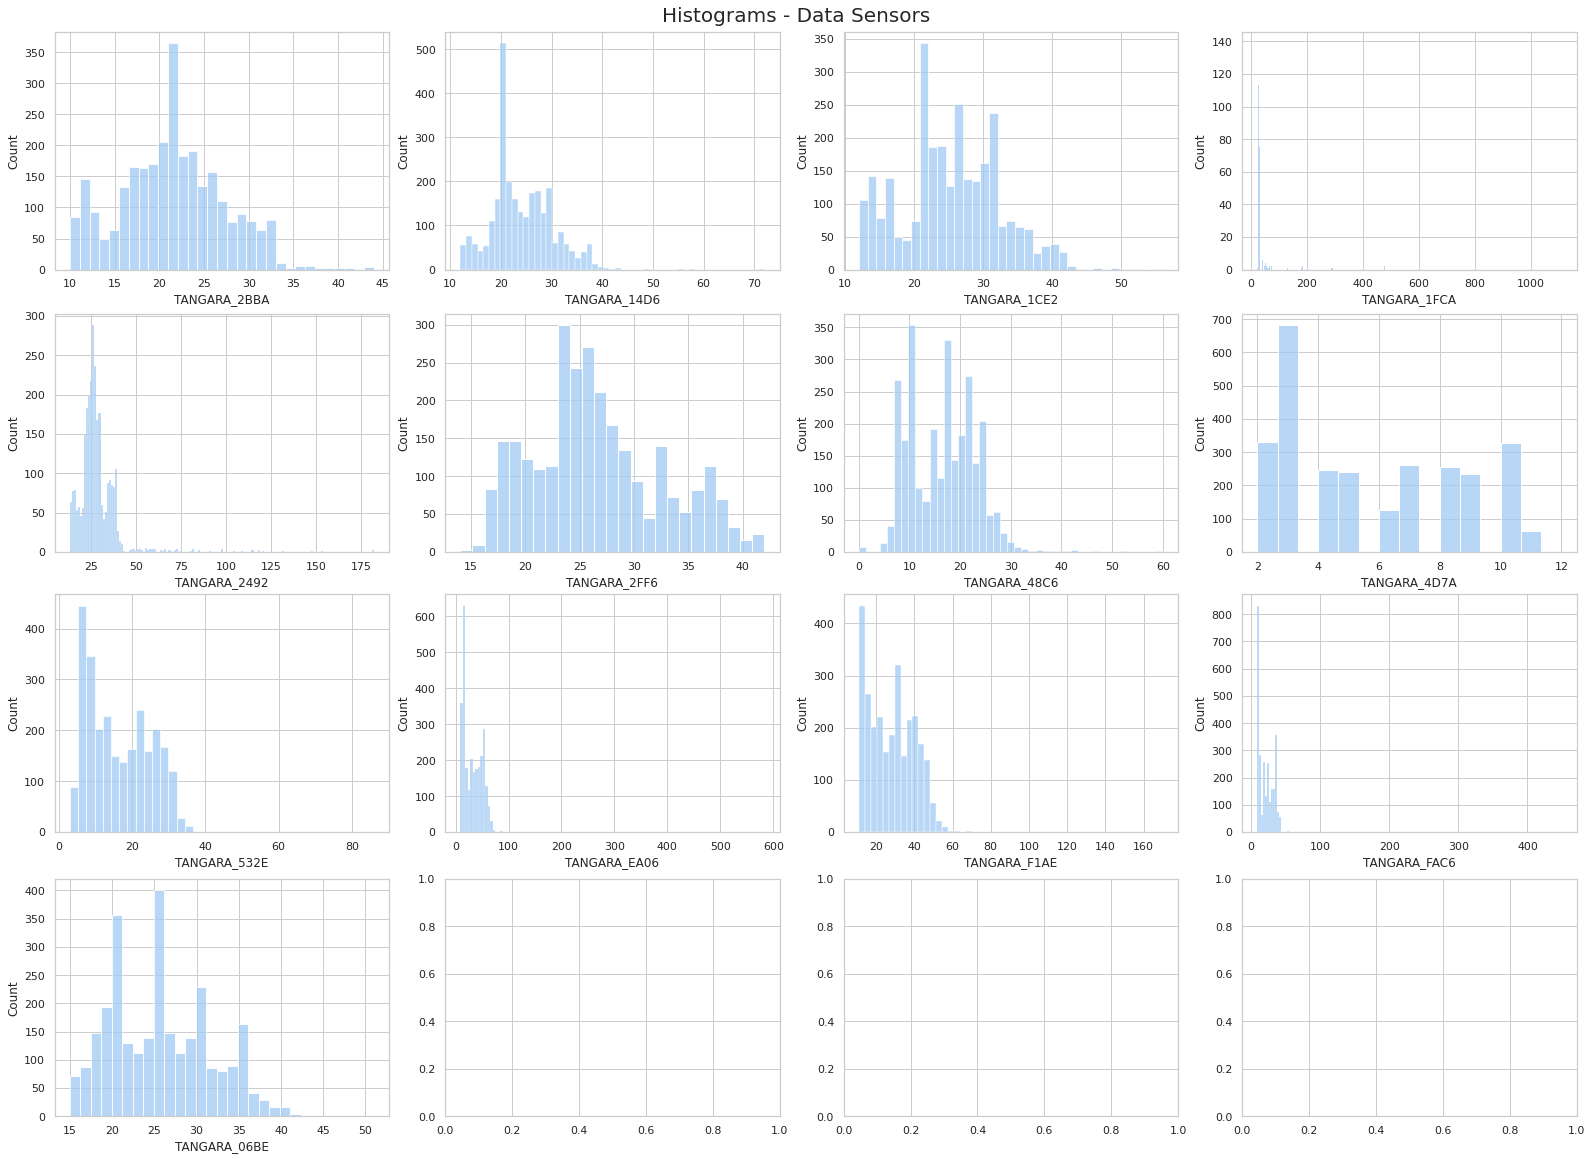

In [5]:
# Plot Histograms
aqi.histplots(pm25_raw)

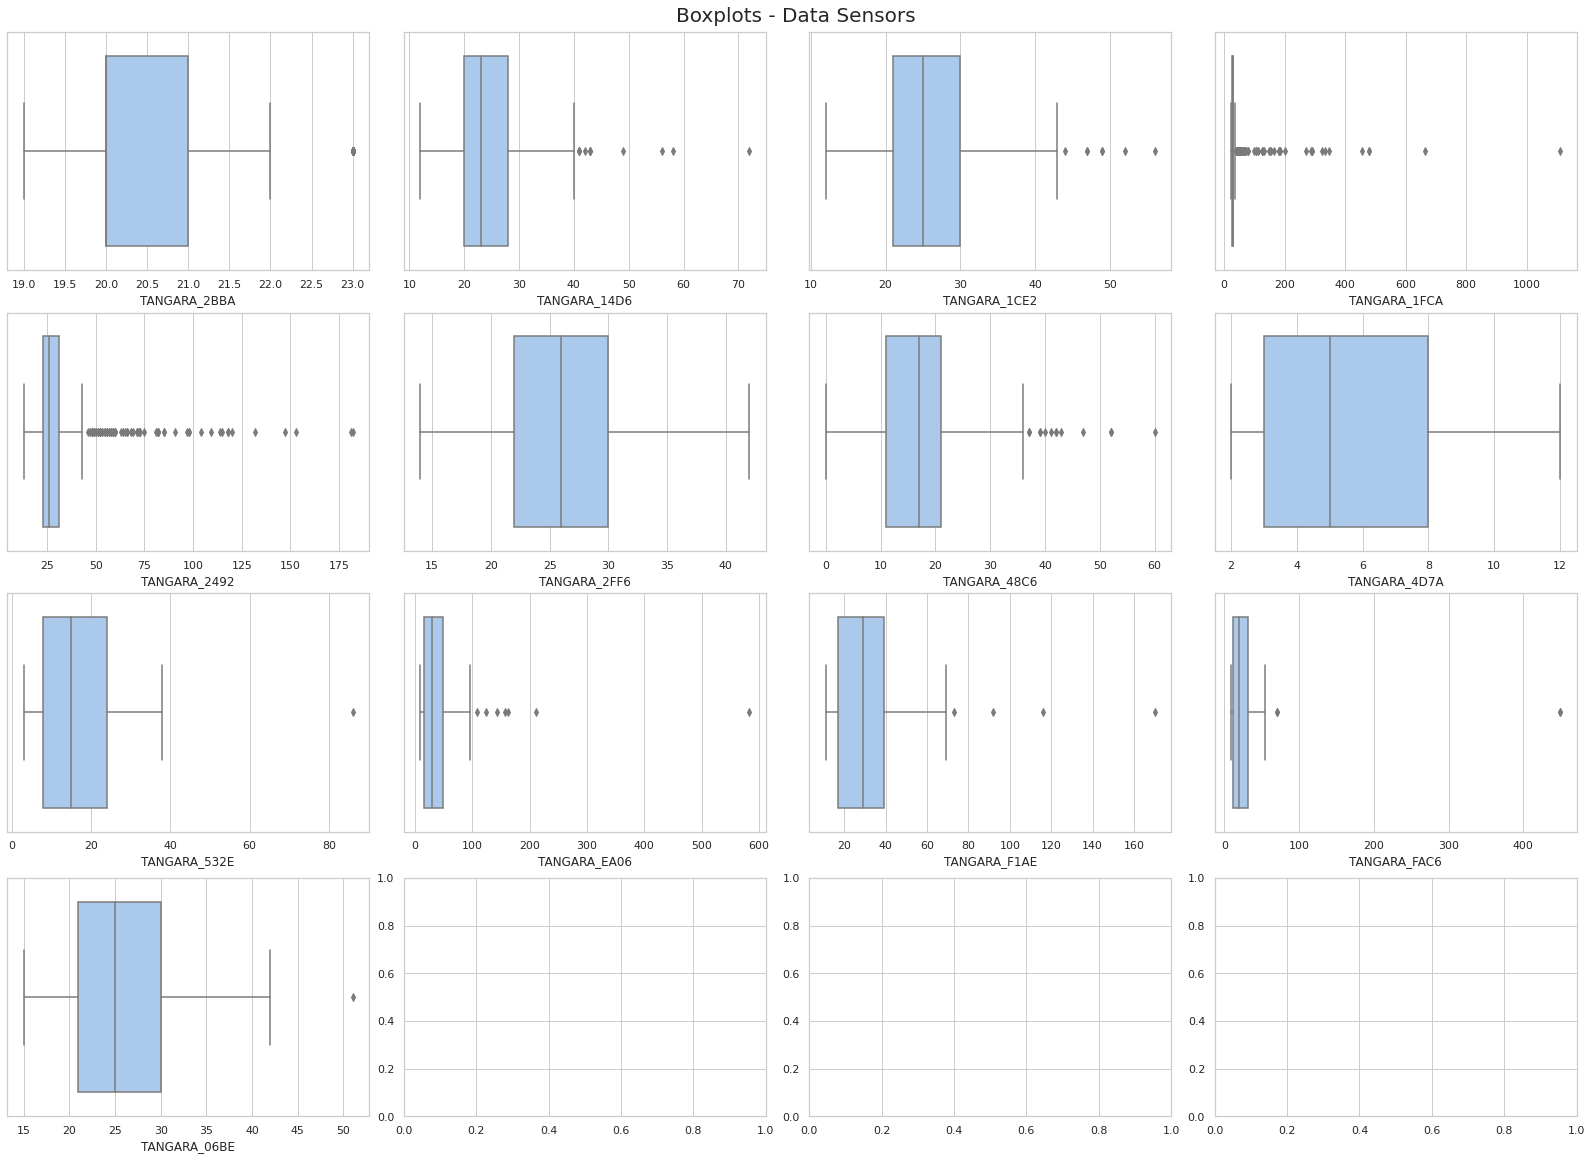

In [6]:
# Plot Boxplots
aqi.boxplots(pm25_raw)

### Max PM25 Value

In [7]:
# Please check the Notebook pm25_nowcast_aqi.ipynb to refer information about this value.
# Max PM25 Value
MAX_PM25_VALUE = aqi.MAX_PM25_VALUE
MAX_PM25_VALUE

500.5

In [8]:
# Drop PM25 Outliers
def drop_pm25_outliers(data_sensors):
    # Each Data Sensor
    for column in data_sensors.columns:
        if column != 'DATETIME':
            # Apply mask to max value allowed, Max AQI Scale Value
            data_sensors[column] = data_sensors[column].mask(data_sensors[column] > MAX_PM25_VALUE, MAX_PM25_VALUE)
            
            # Standard Deviation
            std = data_sensors[column].std()
            # Range = max value - min value
            rango = data_sensors[column].max() - data_sensors[column].min()
            # Quantiles
            media = data_sensors[column].median()
            Q1 = data_sensors[column].quantile(q=0.25)
            Q2 = data_sensors[column].quantile(q=0.50)
            Q3 = data_sensors[column].quantile(q=0.75)
            min_val = data_sensors[column].quantile(q=0)
            max_val = data_sensors[column].quantile(q=1.0)
            # Interquartil Range
            iqr = Q3 - Q1
            # Limites para deteccion de outliers (solo aplica para datos simetricamente distribuidos)**
            min_limit = Q1 - 1.5 * iqr
            max_limit = Q3 + 1.5 * iqr
            # Medidas de Tendencia Central**
            str_resume = f"{column}:\n"\
                        f"std: {std}\n"\
                        f"rango: {rango}\n"\
                        f"media: {media}\n"\
                        f"Q1: {Q1}\n"\
                        f"Q2: {Q2}\n"\
                        f"Q3: {Q3}\n"\
                        f"min_val: {min_val}\n"\
                        f"max_val: {max_val}\n"\
                        f"iqr: {iqr}\n"\
                        f"min_limit: {min_limit}\n"\
                        f"max_limit: {max_limit}\n\n"
            #print(str_resume)

            # Drop Outliers, using max_limit to apply mask and drop outliers
            data_sensors[column] = data_sensors[column].mask(data_sensors[column] > max_limit, None)
    
    return data_sensors

In [9]:
# Eliminar Outliers
pm25_clean = drop_pm25_outliers(pm25_raw.copy())
# Data Frame Sensors
pm25_clean.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21.0,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20.0,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20.0,20.0,24.0,NaN,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21.0,20.0,24.0,NaN,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22.0,22.0,24.0,NaN,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


In [10]:
# Describe Data
pm25_raw.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2838.000000,2747.000000,2796.000000,842.000000,2779.000000,2801.000000,2807.000000,2763.000000,2692.000000,2755.000000,2770.000000,2739.000000,2793.000000
mean,21.417195,24.116491,25.281474,38.681710,27.880533,26.601928,16.470609,5.638075,16.235884,32.560436,28.472924,21.766338,25.704261
std,5.746803,5.982577,6.981280,59.070996,11.151621,5.989012,6.511554,2.852142,8.509186,20.869400,12.251082,15.567362,5.954451
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,29.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,31.000000,31.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,44.000000,72.000000,56.000000,1110.000000,182.000000,42.000000,60.000000,12.000000,86.000000,583.000000,170.000000,449.000000,51.000000


In [11]:
# Describe Data
pm25_clean.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2825.000000,2736.000000,2789.000000,742.000000,2705.000000,2801.000000,2794.000000,2763.000000,2691.000000,2748.000000,2766.000000,2735.000000,2792.000000
mean,21.327788,24.020102,25.221585,28.367925,26.601109,26.601928,16.342878,5.638075,16.209959,32.102620,28.351048,21.418647,25.695201
std,5.604861,5.766191,6.884397,2.175981,6.408280,5.989012,6.234398,2.852142,8.403760,17.128851,11.751590,10.360962,5.936232
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,28.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,30.000000,30.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,37.000000,40.000000,43.000000,37.000000,43.000000,42.000000,36.000000,12.000000,38.000000,96.000000,69.000000,54.000000,42.000000


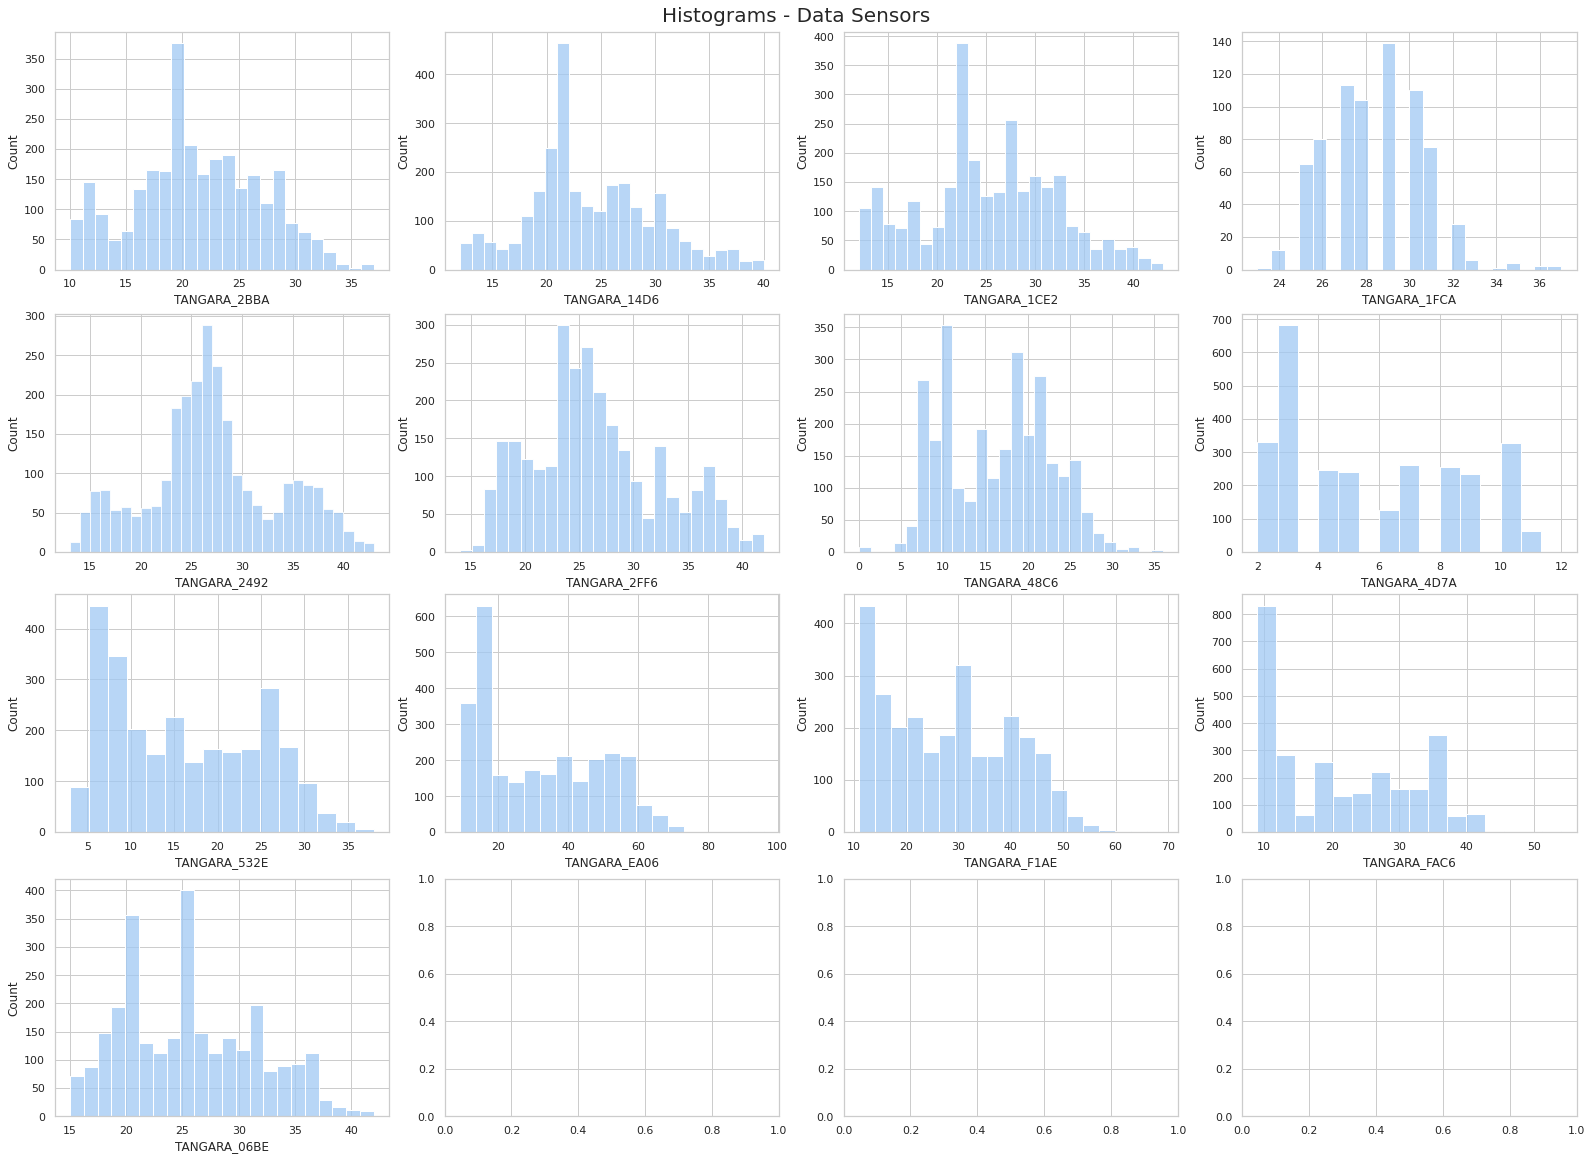

In [12]:
# Plot Histograms
aqi.histplots(pm25_clean)

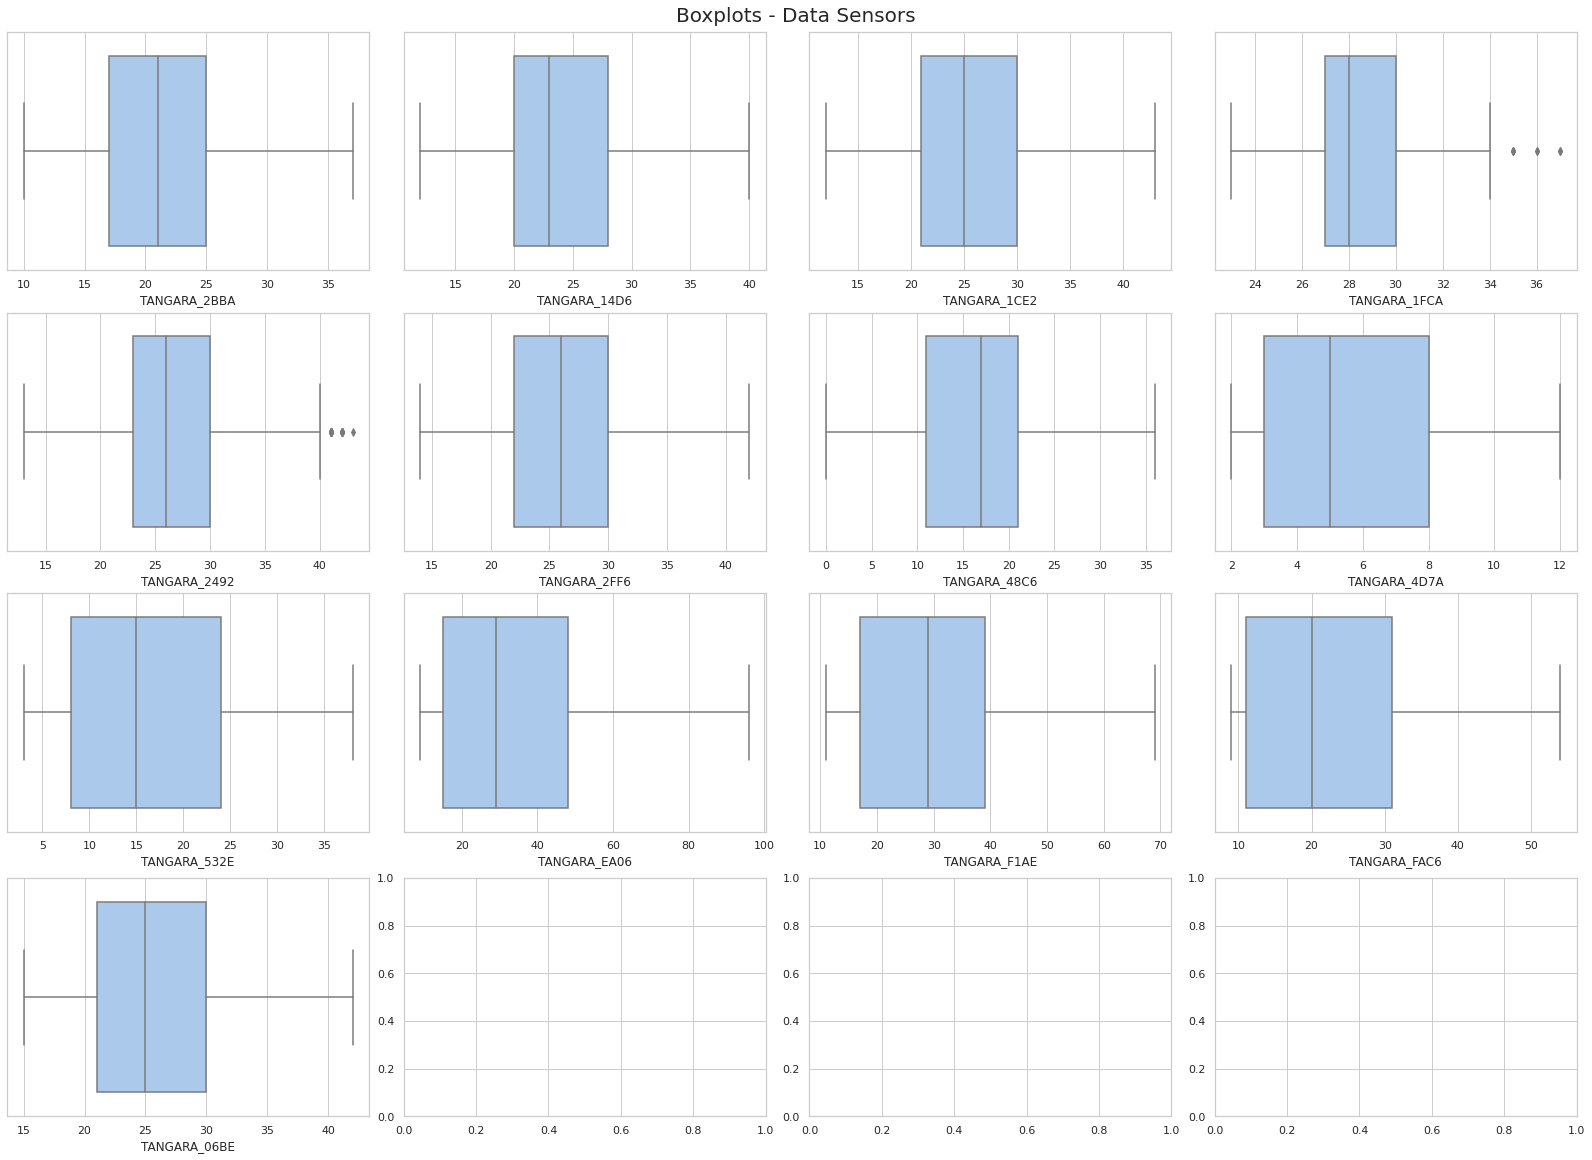

In [13]:
# Plot Boxplots
aqi.boxplots(pm25_clean)

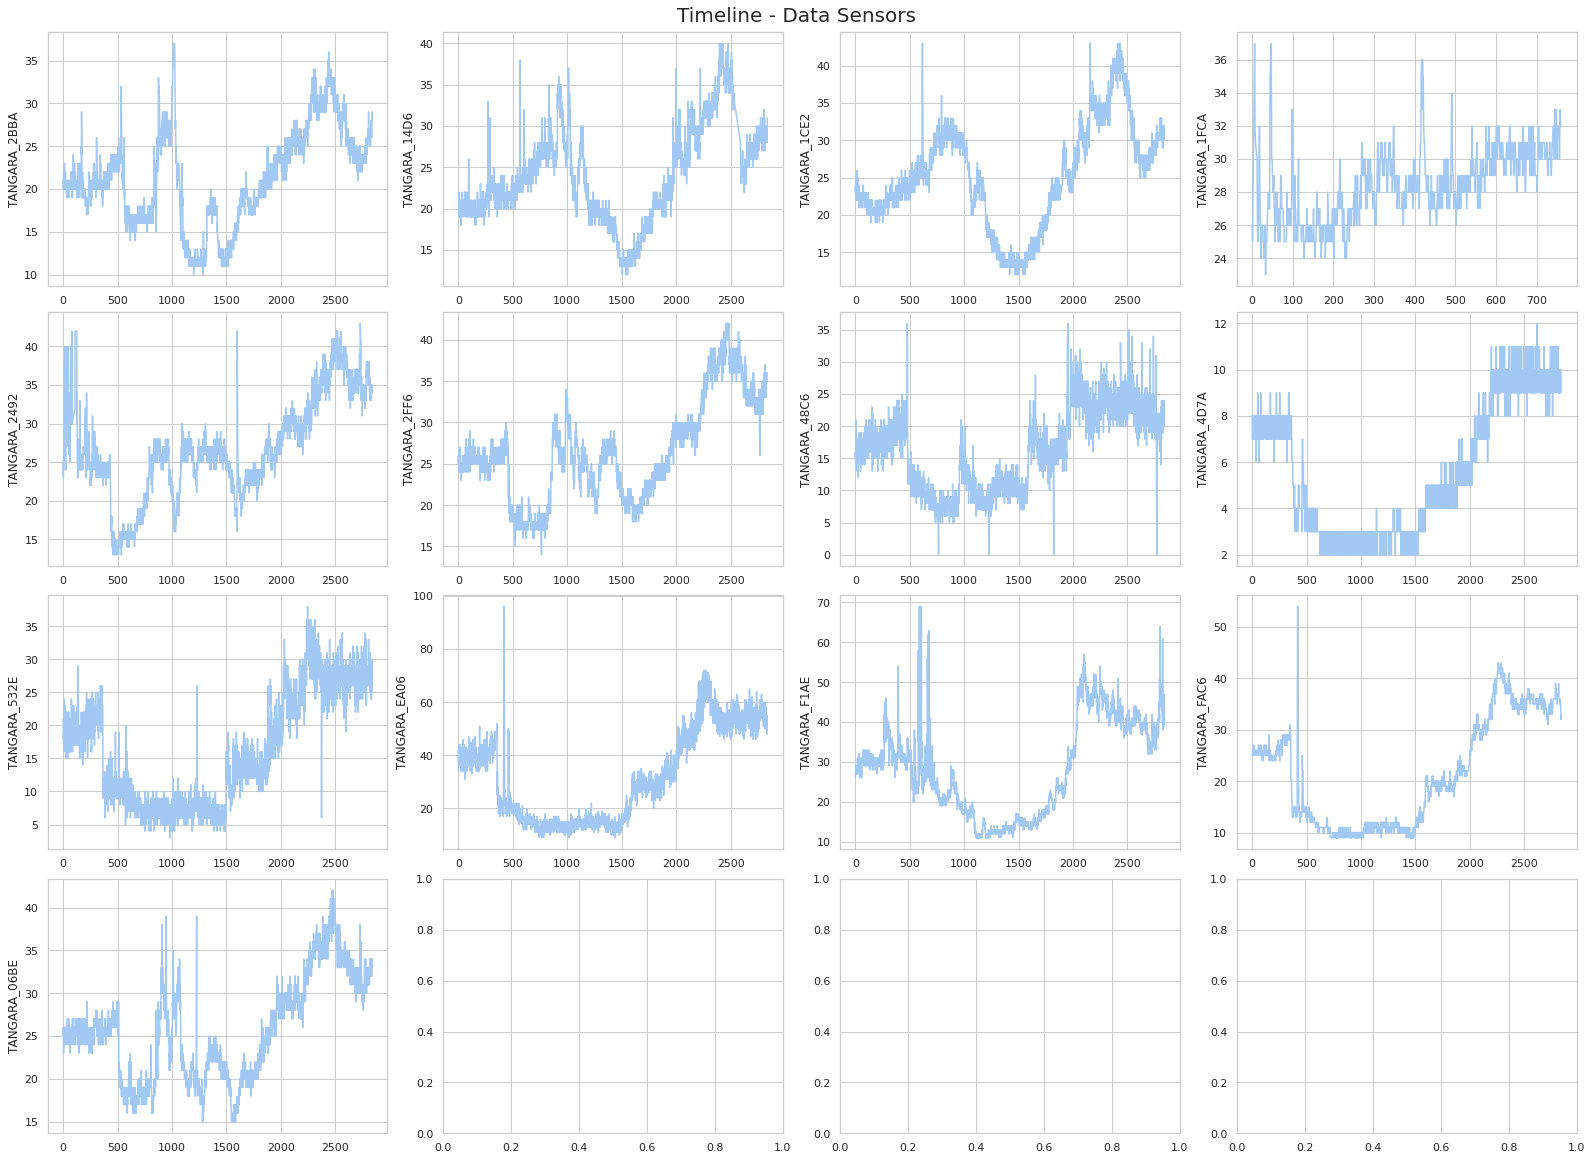

In [14]:
# Plot Lineplots
aqi.lineplots(pm25_clean)

In [15]:
# Save pm25_clean into Catalog
catalog.save('pm25_clean', pm25_clean)

2022-09-21 22:40:11,674 - kedro.io.data_catalog - INFO - Saving data to `pm25_clean` (CSVDataSet)...
